In [1]:
import torch

from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import pytorch3d
from pytorch3d.renderer.cameras import CamerasBase, PerspectiveCameras

import numpy as np

import sys
sys.path.append("..")
from src.utils.utils import *
from src.utils.proj_ray_distance import *

import os
import json
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
# from typing import List, Optional, Union
# from dataclasses import dataclass, fields
# from collections import defaultdict
from src.models.camera_optim_model import CameraOptimNerFormer
from src.models.model import NerFormer

from src.datamodules.nerf_synthetic.nerf_synthetic import NerfSyntheticDataset

from src.datamodules.co3d.dataset.dataset_zoo import dataset_zoo
from src.datamodules.co3d.dataset.dataloader_zoo import dataloader_zoo

In [4]:
checkpoint = torch.load("/home/kmuvcl/NVS/nerformer_savedir/model_epoch_00000000.pth")

In [3]:
model = CameraOptimNerFormer.load_from_checkpoint("../src/models/step_15199_nerf_lego.ckpt").to("cuda")

Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


In [4]:
nerf_synthetic = NerfSyntheticDataset(N_frames=3+10, mode="train", scenes=("lego",))
nerf_synthetic_dataloader = DataLoader(nerf_synthetic, batch_size=1, shuffle=True)

loading ('lego',) for train


In [4]:
# Super-glue
matcher = init_superglue(0)

Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


In [5]:
nerf_data = next(iter(nerf_synthetic_dataloader))

nerf_data["image_rgb"] = nerf_data["image_rgb"].to("cuda")
nerf_data["depth_range"] = nerf_data["depth_range"].to("cuda")

In [7]:
target, srcs = data_to_frame(nerf_data, 3, "nerf_synthetic")

print(target.keys())
print(srcs.keys())

dict_keys(['rgb', 'rgb_path', 'camera', 'depth_range', 'mask'])
dict_keys(['rgb', 'rgb_path', 'camera', 'noise_camera', 'mask'])


In [8]:
tgt_cam = target["camera"]
src_cams = srcs["camera"]

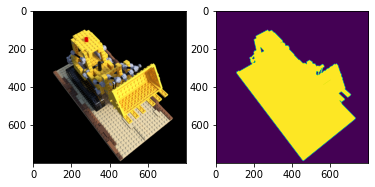

In [9]:
plt.subplot(1, 2, 1)
plt.imshow(srcs["rgb"][0].permute(1, 2, 0).cpu().numpy())

plt.subplot(1, 2, 2)
plt.imshow(srcs["mask"][0][0].cpu().numpy())

In [9]:
category = "teddybear"
task = "singlesequence"
single_sequence_id = 0      # 0 또는 1

datasets = dataset_zoo(
        category=category,
        assert_single_seq=task == "singlesequence",
        dataset_name=f"co3d_{task}",
        test_on_train=False,
        load_point_clouds=False,
        test_restrict_sequence_id=single_sequence_id,
    )

batch_size = 10
batch_num_per_seq = 10

dataloaders = dataloader_zoo(
        datasets,
        batch_size=batch_size,
        dataset_name=f"co3d_multisequence",
        images_per_seq_options=[batch_size * batch_num_per_seq],
    )

dataloader = dataloaders["train"]

Loading Co3D frames from /home/kmuvcl/dataset/CO3D/teddybear/frame_annotations.jgz.
Loading Co3D sequences from /home/kmuvcl/dataset/CO3D/teddybear/sequence_annotations.jgz.
Loading Co3D subset lists from /home/kmuvcl/dataset/CO3D/teddybear/set_lists.json.
Removing images with empty masks.
... filtered 72865 -> 63135
Limitting Co3D dataset to the '['test_known']' subsets.
pick_sequence: ['34_1479_4753']
... filtered 75 -> 1
CO3D Dataset #frames=81
Loading Co3D frames from /home/kmuvcl/dataset/CO3D/teddybear/frame_annotations.jgz.
Loading Co3D sequences from /home/kmuvcl/dataset/CO3D/teddybear/sequence_annotations.jgz.
Loading Co3D subset lists from /home/kmuvcl/dataset/CO3D/teddybear/set_lists.json.
Removing images with empty masks.
... filtered 72865 -> 63135
Limitting Co3D dataset to the '['test_known', 'test_unseen']' subsets.
pick_sequence: ['34_1479_4753']
... filtered 75 -> 1
CO3D Dataset #frames=102
Loading Co3D frames from /home/kmuvcl/dataset/CO3D/teddybear/frame_annotations.j

In [10]:
co3d_data = next(iter(dataloader))

In [11]:
co3d_target, co3d_srcs = data_to_frame(co3d_data, 3, dataset="co3d")

co3d_src_cams = co3d_srcs["camera"].to("cuda")

torch.Size([3, 800, 800, 3])


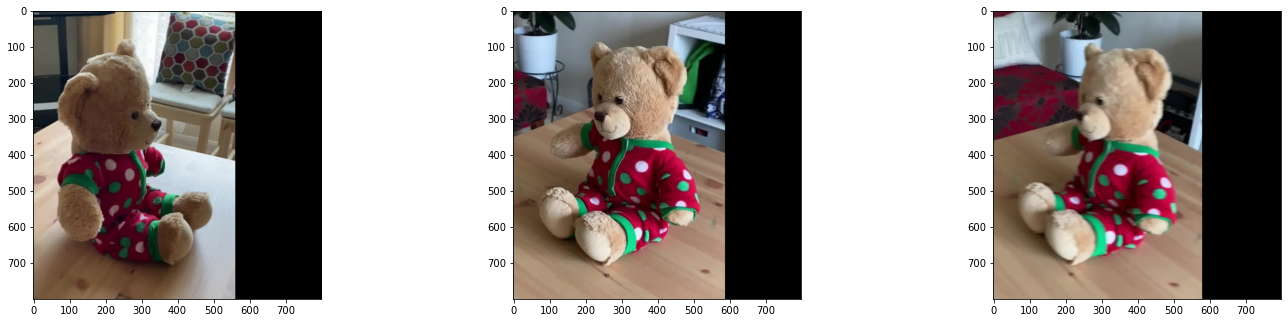

In [12]:
co3d_imgs = co3d_srcs["rgb"].permute(0, 2, 3, 1)
noise_cams = make_noise_camera(co3d_src_cams, rot_noise_factor=0.025, trans_noise_factor=0.05)

print(co3d_imgs.shape)

plt.figure(figsize=(20, 4))
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

for i in range(0, 3):
    plt.subplot(1, 3, i+1)
    plt.imshow(co3d_imgs[i].cpu())

In [13]:
co3d_correspondences = {}

for i in range(0, 3):   
    for j in range(i+1, 3):
        img1 = co3d_imgs[i]
        img2 = co3d_imgs[j]
        
        # Correspondences 추출
        co3d_result = runSuperGlueSinglePair(matcher, img1, img2, 0)
        co3d_result = preprocess_match(co3d_result)
        
        pair = "(%d, %d)"%(i, j)
        
        if co3d_result[0] == None or co3d_result[1] == None:
            print("%s : No correspondences."%pair)
            co3d_correspondences[pair] = None
        else:
            print("%s :"%pair, co3d_result.shape)
            co3d_correspondences[pair] = {}
            
            img_i_points = co3d_result[0]
            img_j_points = co3d_result[1]
            
            co3d_correspondences[pair]["i"] = img_i_points.cpu().tolist()
            co3d_correspondences[pair]["j"] = img_j_points.cpu().tolist()
                

(0, 1) : torch.Size([2, 6, 2])
(0, 2) : torch.Size([2, 1, 2])
(1, 2) : torch.Size([2, 247, 2])


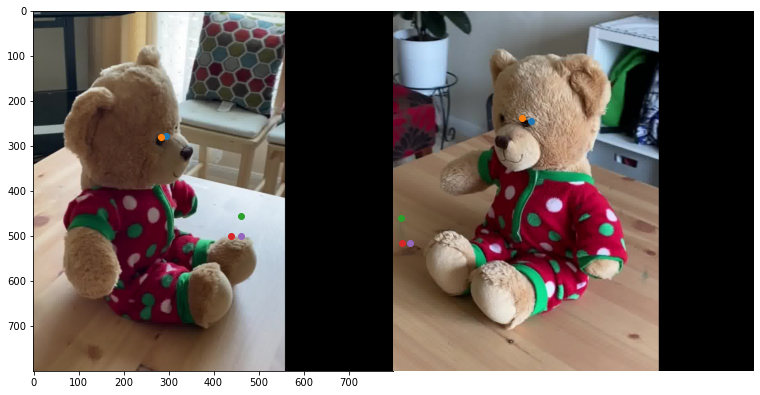

In [15]:
visualize_idxs = [(0, 1)]

plt.figure(figsize=(10, 15))
plt.subplots_adjust(wspace=0, hspace=0.1, left=0, right=1, bottom=0, top=1)

row = 1
for (i, j) in visualize_idxs:
    keypoints = co3d_correspondences["(%d, %d)"%(i, j)]
    if keypoints == None:
        row + 1
        continue
    keypoints_i = keypoints['i']
    keypoints_j = keypoints['j']
    plt.subplot(len(visualize_idxs), 2, 2*row - 1)
    plt.imshow(co3d_imgs[i].cpu())
    
    plt.subplot(len(visualize_idxs), 2, 2*row)
    plt.axis("off")
    plt.imshow(co3d_imgs[j].cpu())
    
    for keypoint_idx in range(0, len(keypoints_i[:5])):
        i_x, i_y = keypoints_i[keypoint_idx]
        j_x, j_y = keypoints_j[keypoint_idx]

        plt.subplot(len(visualize_idxs), 2, 2*row - 1)
        plt.scatter(i_x, i_y)
        
        plt.subplot(len(visualize_idxs), 2, 2*row)
        plt.scatter(j_x, j_y)
    row += 1

In [16]:
img1 = co3d_imgs[0]
img2 = co3d_imgs[1]

# Correspondences 추출
co3d_result = runSuperGlueSinglePair(matcher, img1, img2, 0)
co3d_result = preprocess_match(co3d_result)

In [17]:
co3d_result

tensor([[[294., 278.],
         [283., 279.],
         [461., 455.],
         [439., 501.],
         [461., 501.],
         [479., 503.]],

        [[305., 244.],
         [285., 238.],
         [ 17., 461.],
         [ 19., 516.],
         [ 36., 516.],
         [ 49., 522.]]], device='cuda:0')

torch.Size([5, 800, 800, 3])


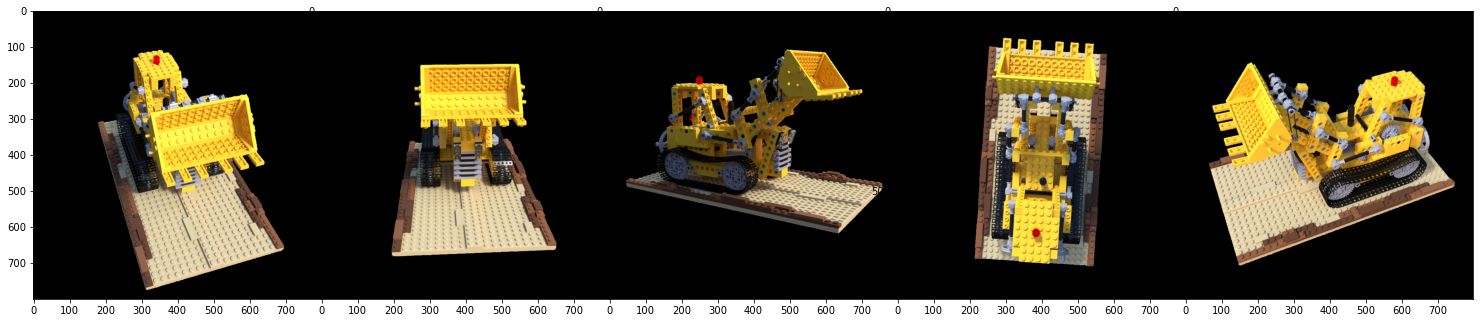

In [29]:
target, srcs = data_to_frame(nerf_data, 5, dataset="nerf_synthetic")

imgs = srcs["rgb"].permute(0, 2, 3, 1)
cams = srcs["camera"]
noise_cams = make_noise_camera(cams, rot_noise_factor=0.025, trans_noise_factor=0.05)

print(imgs.shape)

plt.figure(figsize=(20, 4))
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

for i in range(0, 5):
    plt.subplot(1, 5, i+1)
    plt.imshow(imgs[i].cpu())

In [17]:
img_choices = imgs[1:4]
cam_choices = PerspectiveCameras(
                                    focal_length=cams.focal_length[1:4],
                                    principal_point=cams.principal_point[1:4],
                                    R=cams.R[1:4],
                                    T=cams.T[1:4],
                                ).to(cams.device)
noise_cam_choices = make_noise_camera(cam_choices, rot_noise_factor=0.025, trans_noise_factor=0.05)

In [ ]:
get_noise_camera_figure(cam_choices, [noise_cam_choices], draw_in_one_figure=True)

In [30]:
correspondences = {}


i, j = (1, 2)

img1 = imgs[i]
img2 = imgs[j]

# Correspondences 추출
result = runSuperGlueSinglePair(matcher, img1, img2, 0)
result = preprocess_match(result)

pair = "(%d, %d)"%(i, j)

if result[0] == None or result[1] == None:
    print("%s : No correspondences."%pair)
    correspondences[pair] = None
else:
    print("%s :"%pair, result.shape)
    correspondences[pair] = {}
    
    img_i_points = result[0]
    img_j_points = result[1]
    
    correspondences[pair]["i"] = img_i_points.cpu().tolist()
    correspondences[pair]["j"] = img_j_points.cpu().tolist()
                

(1, 2) : torch.Size([2, 5, 2])


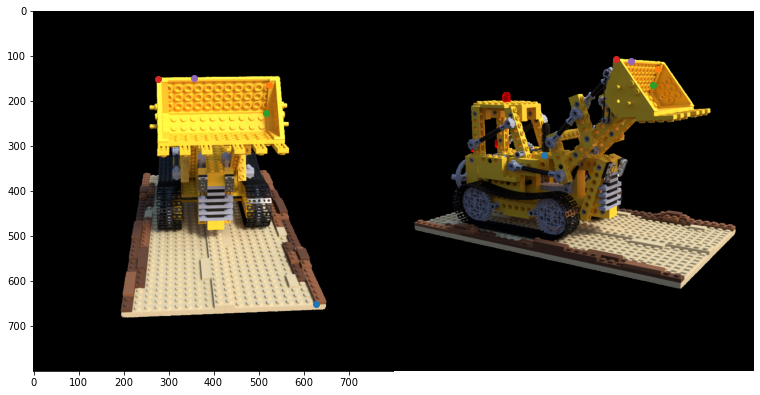

In [31]:
visualize_idxs = [(1, 2)]

plt.figure(figsize=(10, 15))
plt.subplots_adjust(wspace=0, hspace=0.1, left=0, right=1, bottom=0, top=1)

row = 1
for (i, j) in visualize_idxs:
    keypoints = correspondences["(%d, %d)"%(i, j)]
    if keypoints == None:
        row + 1
        continue
    keypoints_i = keypoints['i']
    keypoints_j = keypoints['j']
    plt.subplot(len(visualize_idxs), 2, 2*row - 1)
    plt.imshow(imgs[i].cpu())
    
    plt.subplot(len(visualize_idxs), 2, 2*row)
    plt.axis("off")
    plt.imshow(imgs[j].cpu())
    
    for keypoint_idx in range(0, len(keypoints_i[:20])):
        i_x, i_y = keypoints_i[keypoint_idx]
        j_x, j_y = keypoints_j[keypoint_idx]

        plt.subplot(len(visualize_idxs), 2, 2*row - 1)
        plt.scatter(i_x, i_y)
        
        plt.subplot(len(visualize_idxs), 2, 2*row)
        plt.scatter(j_x, j_y)
    row += 1

In [6]:
ray_sampler, gt_camera_ray_sampler, ray_batch, feature_maps, srcs = model.get_input_data(nerf_data)
initial_src_cams = ray_batch["src_cameras"].clone()

/home/kmuvcl/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/pytorch3d/transforms/transform3d.py:800: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


In [7]:
H, W = ray_sampler.H, ray_sampler.W
gt_img = ray_sampler.rgb.reshape(H, W, 3)
gt_mask = ray_sampler.mask.reshape(H, W, 1)
gt_data = {"img":gt_img, "mask":gt_mask}

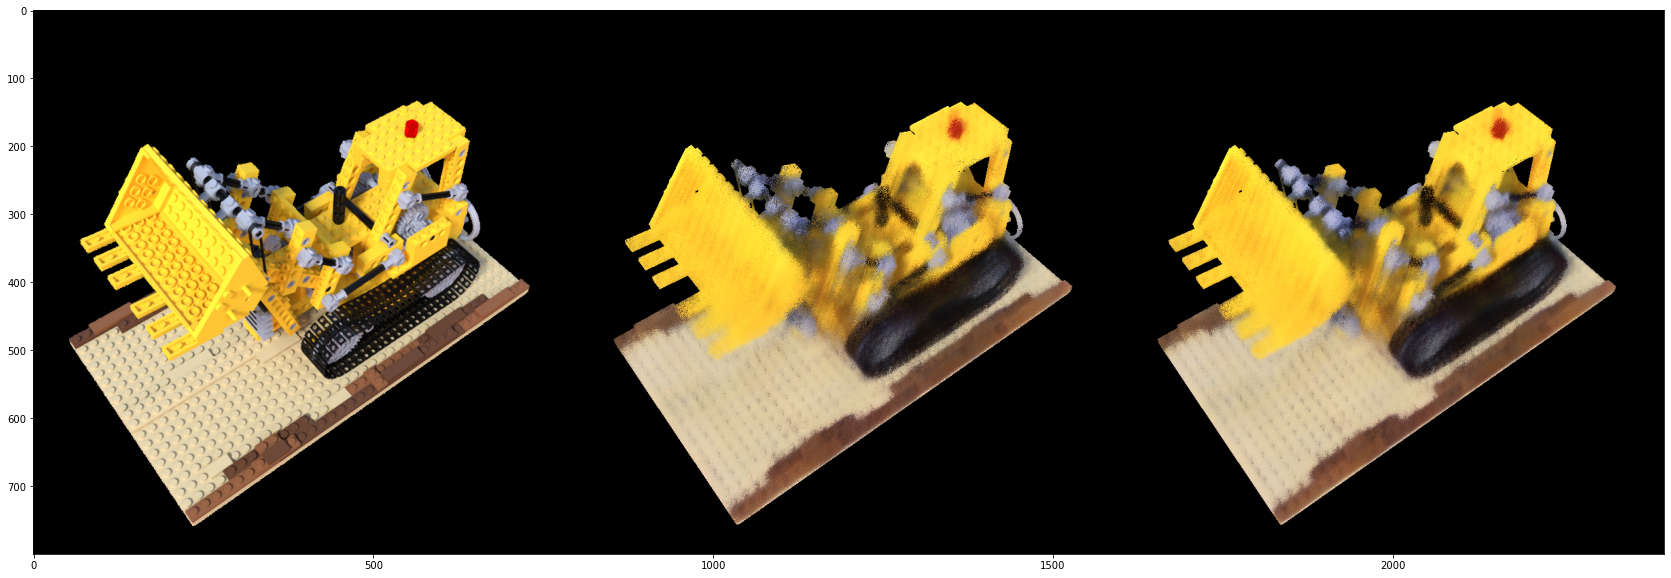

In [9]:
gt_camera_imgs = log_view_to_tensorboard_pl(model.nerformer, model.nerformer, gt_camera_ray_sampler, feature_maps, srcs, model.hparams.pe_dim, gt_data,
                                    model.hparams.chunk_size, model.hparams.render_stride,
                                    model.hparams.N_samples, model.hparams.N_importance, model.hparams.inv_uniform, model.hparams.det, 
                                    model.hparams.model_type, model.hparams.with_colmap, 1, masking=True)
plt.figure(figsize=(30, 10))
plt.imshow(gt_camera_imgs["rgb"].permute(1, 2, 0).cpu().numpy())

/home/kmuvcl/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/pytorch3d/transforms/transform3d.py:800: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


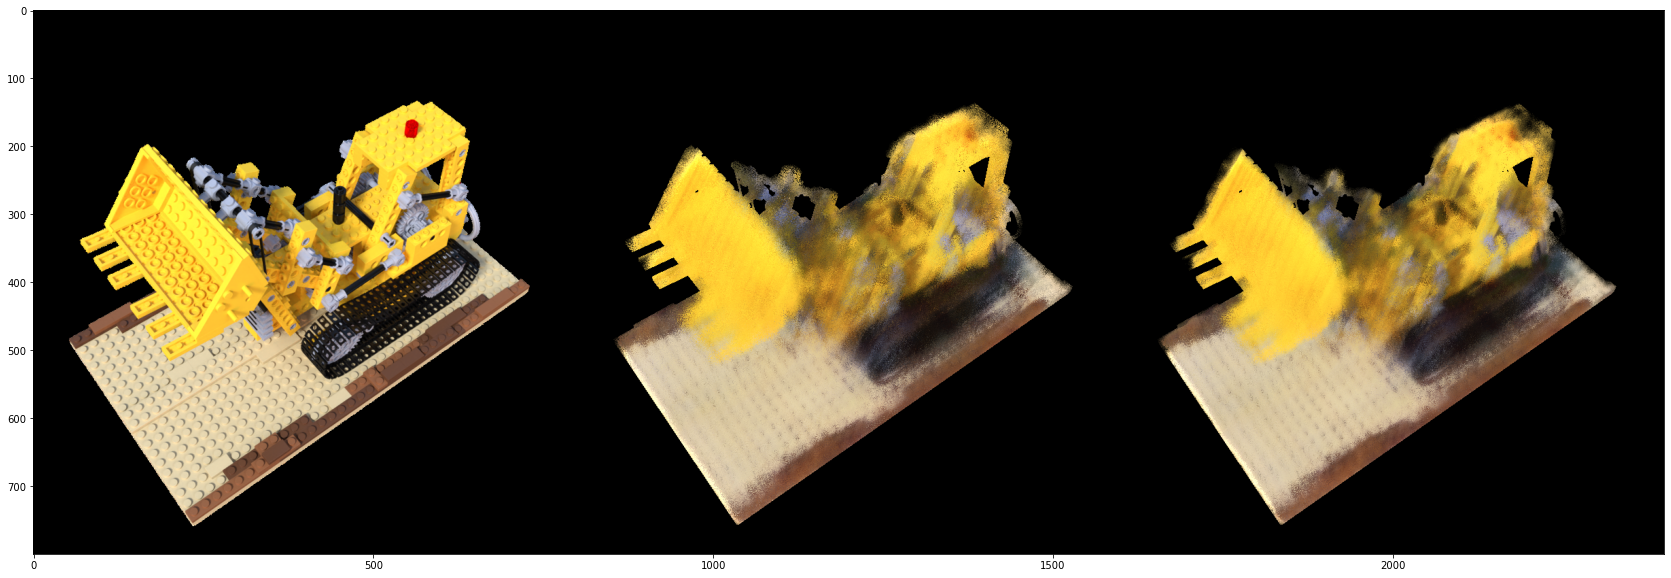

In [11]:
noise_imgs = log_view_to_tensorboard_pl(model.nerformer, model.nerformer, ray_sampler, feature_maps, srcs, model.hparams.pe_dim, gt_data,
                                    model.hparams.chunk_size, model.hparams.render_stride,
                                    model.hparams.N_samples, model.hparams.N_importance, model.hparams.inv_uniform, model.hparams.det, 
                                    model.hparams.model_type, model.hparams.with_colmap, 1, masking=True)
plt.figure(figsize=(30, 10))
plt.imshow(noise_imgs["rgb"].permute(1, 2, 0).cpu().numpy())

In [42]:
result.shape

torch.Size([2, 355, 2])

In [34]:
pair_rays = get_pair_rays((1, 2), cams, 800, 800, result)

In [18]:
co3d_pair_rays = get_pair_rays((0, 1), co3d_src_cams, 800, 800, co3d_result)

In [27]:
p1_in_img0, p0_in_img1 = proj_ray_dist_loss_single(co3d_result[0], co3d_result[1], co3d_src_cams, (1, 2), co3d_pair_rays, 
                                                    "train", 800, 800, only_projection_points=True, projection_point_idx=1, proj_ray_dist_threshold=10.)

In [31]:
co3d_correspondences.keys()

dict_keys(['(0, 1)', '(0, 2)', '(1, 2)'])

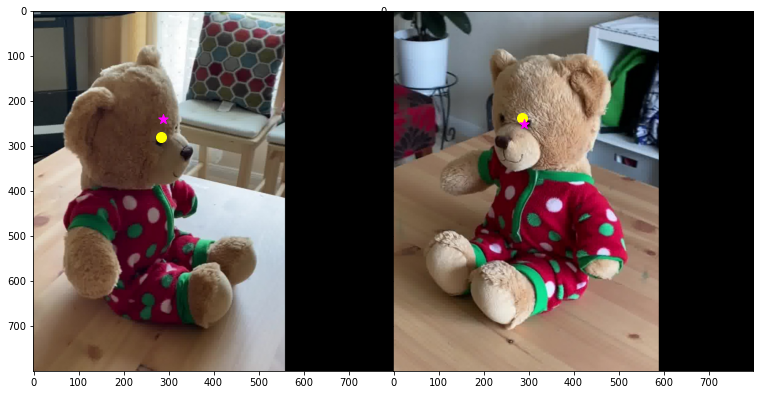

In [28]:
visualize_idxs = [(0, 1)]

plt.figure(figsize=(10, 15))
plt.subplots_adjust(wspace=0, hspace=0.1, left=0, right=1, bottom=0, top=1)


for (i, j) in visualize_idxs:
    keypoints = co3d_correspondences["(%d, %d)"%(i, j)]
    
    keypoint_idx = 1
  
    i_x, i_y = keypoints_i[keypoint_idx]
    j_x, j_y = keypoints_j[keypoint_idx]

    plt.subplot(1, 2, 1)
    plt.imshow(co3d_imgs[i].cpu())
    plt.scatter(i_x, i_y, s=100, c="yellow")
    p1_in_img0_ = p1_in_img0[0].cpu()
    plt.scatter(p1_in_img0_[0], p1_in_img0_[1], s=100, c="magenta", marker='*')
    
    plt.subplot(1, 2, 2)
    plt.imshow(co3d_imgs[j].cpu())
    plt.scatter(j_x, j_y, s=100, c="yellow")
    p0_in_img1_ = p0_in_img1[0].cpu()
    plt.scatter(p0_in_img1_[0], p0_in_img1_[1], s=100, c="magenta", marker='*')

In [27]:
print(p1_in_img0)
print(p0_in_img1)

tensor([[225.1275, 218.6147]], device='cuda:0')
tensor([[414.9875, 230.9836]], device='cuda:0')


In [44]:
keypoint_idx = 4
p1_in_img0, p0_in_img1 = proj_ray_dist_loss_single(result[0], result[1], src_cams, (1, 2), pair_rays, 
                                                    "train", 800, 800, only_projection_points=True,
                                                    projection_point_idx=keypoint_idx, 
                                                    proj_ray_dist_threshold=10.)

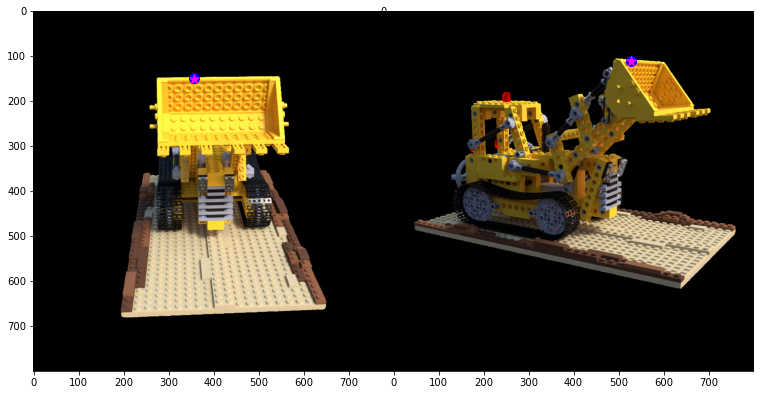

In [45]:
visualize_idxs = [(1, 2)]

plt.figure(figsize=(10, 15))
plt.subplots_adjust(wspace=0, hspace=0.1, left=0, right=1, bottom=0, top=1)


i, j = (1, 2)
keypoints = correspondences["(%d, %d)"%(i, j)]

i_x, i_y = keypoints_i[keypoint_idx]
j_x, j_y = keypoints_j[keypoint_idx]

plt.subplot(1, 2, 1)
plt.imshow(imgs[i].cpu())
plt.scatter(i_x, i_y, s=100, c="blue")
p1_in_img0_ = p1_in_img0[0].cpu()
plt.scatter(p1_in_img0_[0], p1_in_img0_[1], s=100, c="magenta", marker='*')

plt.subplot(1, 2, 2)
plt.imshow(imgs[j].cpu())
plt.scatter(j_x, j_y, s=100, c="blue")
p0_in_img1_ = p0_in_img1[0].cpu()
plt.scatter(p0_in_img1_[0], p0_in_img1_[1], s=100, c="magenta", marker='*')